<a href="https://colab.research.google.com/github/Dohessiekan/Sound_Clustering/blob/main/Dohessiekan_Xavier_Gnondoyi_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Make allNecessary Imports

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os


In [6]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/Assignement1/unlabelled_sounds"
audio_files = [f for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]



features = []
min_length = float("inf")

# Extract Features
for file in audio_files:
    file_path = os.path.join(unlabelled_data_path, file)
    audio, sr = librosa.load(file_path, sr=None)
    min_length = min(min_length, len(audio))  # Track shortest audio

# Set dynamic n_fft based on the shortest audio file
n_fft = min(2048, min_length)
hop_length = n_fft // 4

for file in audio_files:
    file_path = os.path.join(unlabelled_data_path, file)
    audio, sr = librosa.load(file_path, sr=None)

    # Pad if audio is too short
    if len(audio) < n_fft:
        pad_width = n_fft - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    features.append(np.mean(mel_spec_db, axis=1))  # Take mean along time axis

features_array = np.array(features)

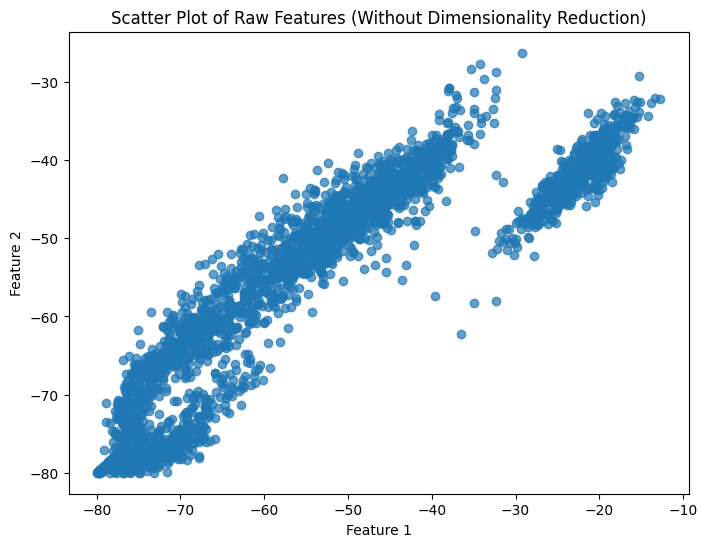

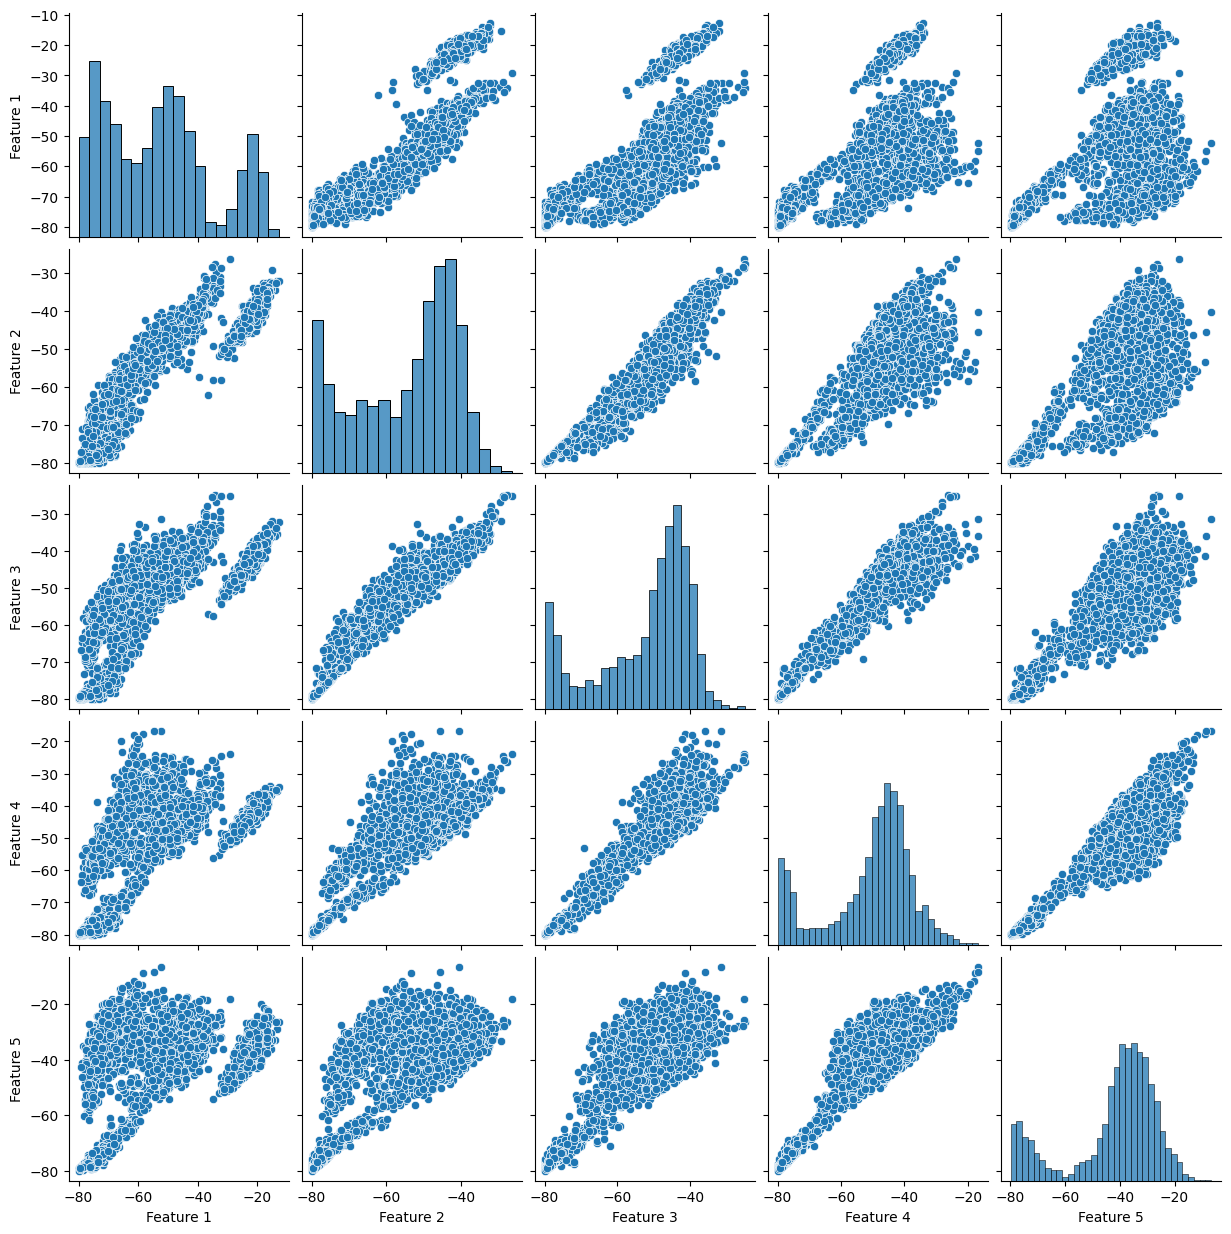

In [7]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
Dimensionality reduction is important because it helps simplify complex data by reducing the number of features while retaining essential information. This has several key benefits:

Improved Model Performance: Reducing irrelevant or redundant features can lead to better model performance by preventing overfitting and improving generalization.
Faster Computation: With fewer dimensions, algorithms run faster, reducing computational costs and memory usage, especially for large datasets.
Easier Visualization: It enables data to be visualized in 2D or 3D, making it easier to understand and interpret complex relationships.
Noise Reduction: It helps eliminate noisy or less informative features, improving the signal-to-noise ratio.




(*Document any challenges/errors from the above experiments.*)

About some chalenges I faced during the preview, it was about to extract the feature, it was somehow difficult, then after that try to plot each feature and about those 5 firsst features too.

- Dimensionality: The feature has a higher number of dimension wich can affect the plot about the important of the dimension of my data, so I faced those issue during the first code I was writing.

- About the code provide , just plot only two feature, It can be misleading but my data is high-dimensional, and i was facing this error , but I try to improve it.

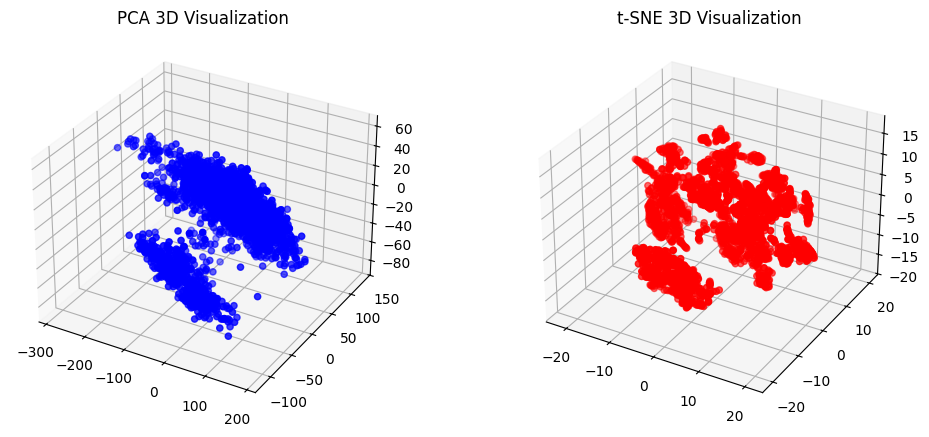

In [8]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 5))

# PCA 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='b', marker='o')
ax1.set_title('PCA 3D Visualization')

# t-SNE 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='r', marker='o')
ax2.set_title('t-SNE 3D Visualization')

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)
This comparaison shows each method reduce hight-dimension data into a 3D.

Key observation:

1. PCA 3D Visualization (Left, Blue)

The data appears more spread out, with some structure but less distinct separation between groups.

PCA is a linear transformation, meaning it captures global variance but might not be as effective in identifying complex structures.



2. t-SNE 3D Visualization (Right, Red)

The data points seem more compact and form clearer clusters compared to PCA.

t-SNE is a non-linear technique that preserves local structures better, making it effective in revealing natural clusters in the data.




Which Method Provides Better Separability?

t-SNE provides better cluster separability because it preserves local neighborhood relationships more effectively than PCA.

PCA is useful for reducing dimensionality while maintaining variance, but it doesn't always separate clusters well.

t-SNE excels at revealing hidden structures in data, making it better for clustering tasks.

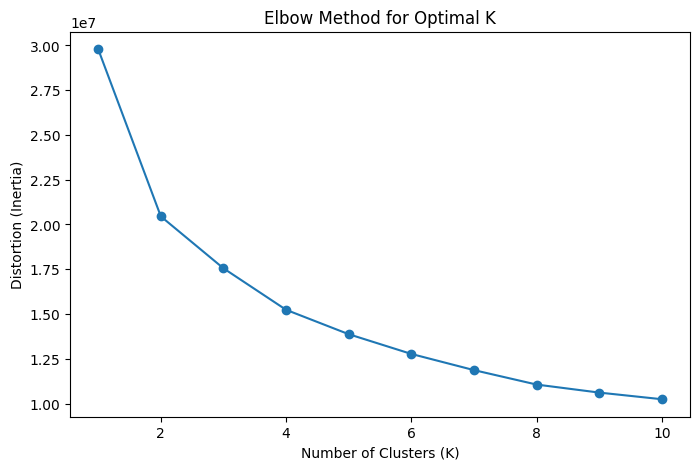

In [9]:
# Elbow Method to find optimal K
distortions = []
K_range = range(1, 11)  # Checking clusters from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_array)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method result
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Set optimal K
optimal_k = 3

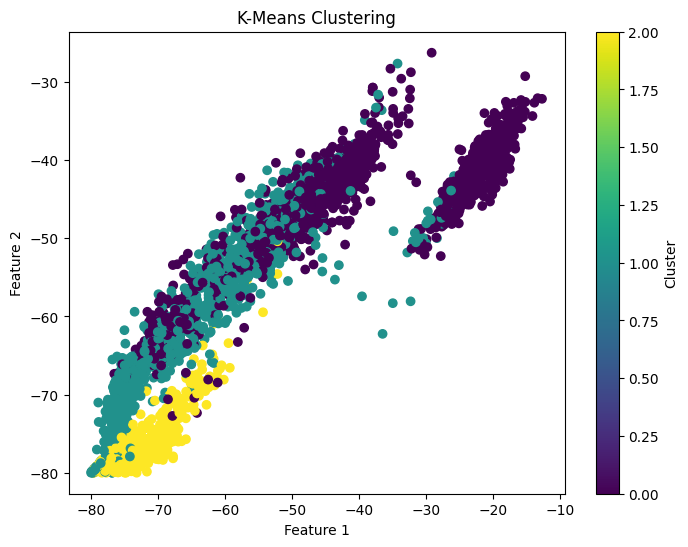

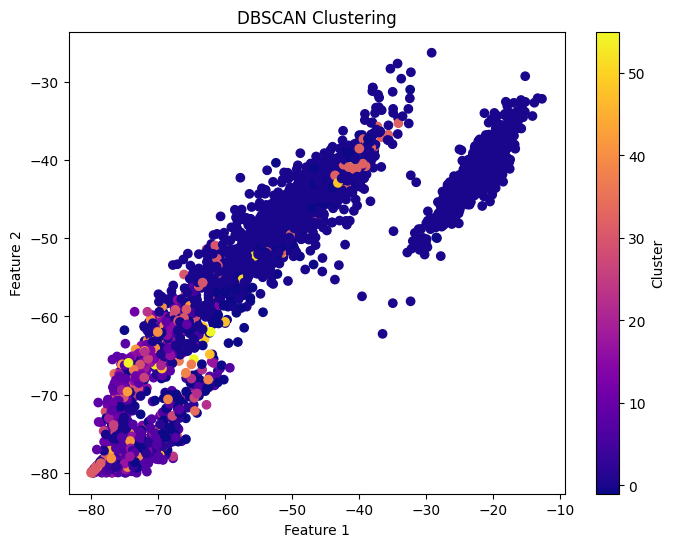

In [10]:
# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=2.5, min_samples=2)  # Adjust values
dbscan_labels = dbscan.fit_predict(features_array)

from sklearn.preprocessing import StandardScaler

#scale the data:
features_scaled = StandardScaler().fit_transform(features_array)
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Scatter Plot for K-Means
plt.figure(figsize=(8, 6))
plt.scatter(features_array[:, 0], features_array[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering")
plt.colorbar(label='Cluster')
plt.show()

# Scatter Plot for DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(features_array[:, 0], features_array[:, 1], c=dbscan_labels, cmap='plasma', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering")
plt.colorbar(label='Cluster')
plt.show()

In [11]:
# print("Unique DBSCAN labels:", set(dbscan_labels))

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print Evaluation Results
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.2694, Davies-Bouldin Index: 1.3360
DBSCAN - Silhouette Score: -0.1986, Davies-Bouldin Index: 1.6114


### Discuss the results (max 5 lines)

---


(Compare K-Means and DBSCAN performance based on the outputs.)

The K-Means algorithm performs better than DBSCAN, based on the Silhouette Score and Davies-Bouldin Index. K-Means has a positive Silhouette Score (0.2694), indicating average clustering quality with some well-formed clusters, while DBSCAN’s negative Silhouette Score (-0.1986) points to poor clustering and potential misclassification or noise. Additionally, K-Means has a lower Davies-Bouldin Index (1.3360), suggesting better separation between clusters compared to DBSCAN (1.6114), which has worse separation. Therefore, K-Means demonstrates more promising clustering performance for this dataset.

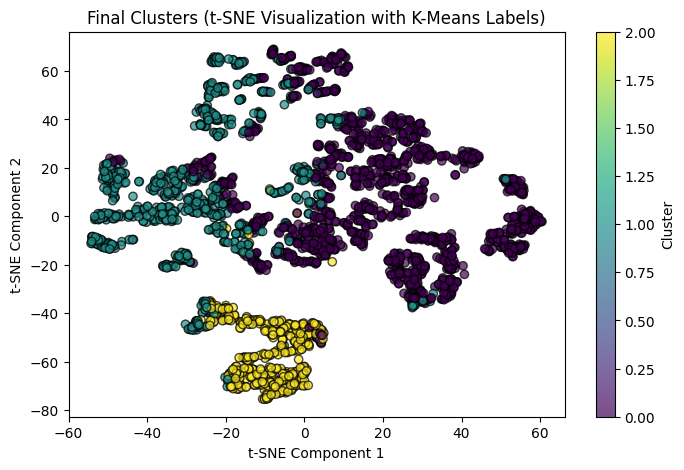

In [12]:
# Apply t-SNE (Reduce to 2D for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)


plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.colorbar(label="Cluster")
plt.show()

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.


1. Why Dimensionality Reduction Helped (or Didn't) in Clustering:
Dimensionality reduction techniques, such as PCA (Principal Component Analysis) or t-SNE (t-distributed Stochastic Neighbor Embedding), are often used to simplify complex datasets, making them more suitable for clustering. They reduce the number of features while maintaining the essential structure of the data. This helps in:

Improved Computational Efficiency: Reducing dimensions leads to faster computations, which is crucial when working with large datasets.
Reduced Noise: High-dimensional data often contains noise and irrelevant features. Dimensionality reduction can eliminate some of this noise, making clustering algorithms more effective by focusing on the most meaningful patterns.
Better Visualization: High-dimensional data is hard to visualize. Reducing dimensions (e.g., to 2D or 3D) allows for visual inspection, which can help in understanding clustering results and refining the analysis.
However, dimensionality reduction doesn't always help in every clustering scenario. It may:

Lose Important Information: Reducing dimensions could lead to the loss of valuable features that are essential for clustering, which may decrease the accuracy of the clustering results.
Over-simplify Data: In some cases, essential patterns or structures might be overlooked if dimensions are reduced too aggressively.
In summary, dimensionality reduction can be very beneficial in clustering when the data has many irrelevant features or noise, but it needs to be carefully applied to avoid losing critical information.

2. Why Certain Clustering Methods Worked Better:
Different clustering algorithms have strengths and weaknesses depending on the nature of the data and the task at hand. Here's why certain methods may have performed better:

K-Means Clustering: This algorithm works well when the data is relatively spherical and well-separated. If the dataset had well-defined clusters with similar sizes and shapes, K-Means would perform efficiently. It is computationally efficient, especially with reduced dimensions.
DBSCAN (Density-Based Spatial Clustering of Applications with Noise): This method works better for datasets with noise and clusters of varying shapes. If the dataset had clusters that weren't spherical or contained outliers, DBSCAN would perform better. It identifies areas of high density and naturally separates noise points, unlike K-Means.
Hierarchical Clustering: This method is useful when the data has a hierarchical structure, such as nested groups. It performed better in cases where the dataset had varying levels of granularity or when visualizing dendrograms helped understand the cluster hierarchy.
Clustering methods that worked well typically matched the underlying structure of the data. If the clusters were compact and well-separated, K-Means likely performed better. If the dataset contained noise or irregularly shaped clusters, DBSCAN would likely be more effective.

3. Relating Findings to Real-World Clustering Challenges:
Clustering is a fundamental task in many real-world applications, and the challenges encountered in this analysis are directly applicable to these scenarios:

Customer Segmentation: In marketing, businesses often use clustering to group customers based on purchasing behavior or demographics. Here, dimensionality reduction could be useful when dealing with a large number of customer features. Depending on the distribution of the data, methods like K-Means or DBSCAN may be more effective for segmenting customers into meaningful groups.
Anomaly Detection: In fraud detection (e.g., credit card fraud), clustering helps identify unusual transactions. Dimensionality reduction helps isolate patterns from noise. DBSCAN may be more successful in identifying outliers and irregular patterns that deviate from normal behavior.
Image Segmentation: In image processing, clustering can be used for segmenting images into regions. Dimensionality reduction, particularly techniques like t-SNE, may help to reduce the complexity of image features, improving the accuracy and efficiency of the segmentation.
Social Network Analysis: In large social networks, clustering can group users with similar interests. Here, dimensionality reduction might be needed when dealing with a high-dimensional user behavior dataset. Depending on the network structure, DBSCAN might detect isolated groups better than K-Means.



In these real-world applications, the key takeaway is that selecting the right clustering method depends heavily on the characteristics of the data. Dimensionality reduction is a useful tool for improving clustering performance, but careful consideration of the dataset's properties and clustering algorithm limitations is crucial for achieving meaningful results.